In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as krs
import numpy
from keras.datasets import mnist
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, roc_curve, auc, accuracy_score
from scipy.cluster.vq import kmeans2
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import os
from google.colab import drive

In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/sukhanich-lapochka')

Mounted at /content/drive


In [8]:
nw = 28
nh = 28
num_hide = 98
num_classes = 10
n_count = 32
Conv2D_count = (3, 3)

# загружаем примеры обучения mnist (рукописные цифры)
(trainx, trainy), (testx, testy) = mnist.load_data()
# нормируем от -1 до 1 изображения цифр
all_image = (trainx/255.0-0.5)*1.999
# добавляем дополнительное измерение соответствующее одной цветовой карте
all_image = numpy.expand_dims(all_image, axis=3)

# задаем входной слой экодера высота на ширину на количество карт
encoder_input = krs.layers.Input(shape=(nw,nh,1))
# задаем сверточный слой с 32 фильтрами-картами и фильтрами 3 на 3
# оставляет тот же размер карты 28*28
lay = krs.layers.Conv2D(n_count, Conv2D_count, strides = (2,2), activation='relu', padding='same')(encoder_input)
lay = krs.layers.Dropout(0.15)(lay)
lay = krs.layers.Conv2D(n_count * 2, Conv2D_count, strides = (2,2),activation='relu', padding='same')(lay)
# добавляем слой прореживания
lay = krs.layers.Dropout(0.15)(lay)
lay = krs.layers.Conv2D(n_count * 4, Conv2D_count, strides = (2,2),activation='relu', padding='same')(lay)
lay = krs.layers.Dropout(0.15)(lay)
lay = krs.layers.Conv2D(n_count * 8, Conv2D_count, strides = (2,2),activation='relu', padding='same')(lay)
# слой который многомерный тензорный слой превращает в плоский вектор
lay = krs.layers.Flatten()(lay)

# выходной кодирующий слой
lay_out_encoder = krs.layers.Dense(num_hide, activation="linear", name='den4')(lay)
# создаем сеть энкодера
encoder = krs.Model(encoder_input, lay_out_encoder)

# создание сети декодера, входной слой
decoder_input = krs.layers.Input(shape=(num_hide,))
lay = krs.layers.Dense(n_count * 4 * 7 * 7)(decoder_input)
# преобразуем плоский слой в многомерный тензор 7*7*128
lay = krs.layers.Reshape(target_shape=(7,7,n_count * 4))(lay)
lay = krs.layers.Conv2D(n_count * 4, Conv2D_count, activation='relu', padding='same')(lay)
# повышаем размерность карты в два раза, будет 14*14
# можно использовать билинейную интерполяцию если хотите
lay = krs.layers.UpSampling2D(size=(2,2))(lay)
lay = krs.layers.Conv2D(n_count * 2, Conv2D_count, activation='relu', padding='same')(lay)
lay = krs.layers.UpSampling2D(size=(2,2))(lay)
lay_out_decoder = krs.layers.Conv2D(1, Conv2D_count, activation='tanh', padding='same')(lay)
# создаем сеть декодера
decoder = krs.Model(decoder_input,lay_out_decoder)

# объединяем обе сети в автоэнкодер
lay_out = decoder(lay_out_encoder)
autoencoder = krs.Model(encoder_input,lay_out)
# полученный вид модели сохраняем в файле в виде изображения
krs.utils.plot_model(autoencoder, to_file='.\out\autoencoder.png', show_shapes=True)
# компилируем модель автоэнкодера с функцией потерь mse и скоростью обучения 0.0002
autoencoder.compile(loss='mean_squared_error', optimizer=krs.optimizers.Adam(learning_rate=0.0002),
                  metrics=['accuracy', krs.metrics.Precision(), krs.metrics.Recall()])
# запускаем 40 эпох обучения с размером батча 4000
ep = 40
autoencoder.fit(x = all_image,y = all_image,batch_size = 4000,epochs = ep)
encoder.save('encoder_model.keras')

Epoch 1/40
15/15 [==============================] - 16s 907ms/step - loss: 0.5807 - accuracy: 0.0000e+00 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 2/40
15/15 [==============================] - 14s 908ms/step - loss: 0.2877 - accuracy: 0.0000e+00 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 3/40
15/15 [==============================] - 13s 866ms/step - loss: 0.2684 - accuracy: 0.0000e+00 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 4/40
15/15 [==============================] - 13s 849ms/step - loss: 0.2649 - accuracy: 0.0000e+00 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 5/40
15/15 [==============================] - 13s 844ms/step - loss: 0.2620 - accuracy: 0.0000e+00 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 6/40
15/15 [==============================] - 13s 852ms/step - loss: 0.2573 - accuracy: 0.0000e+00 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 7/40
15/15 [==============================] - 13s 866ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 521ms/step


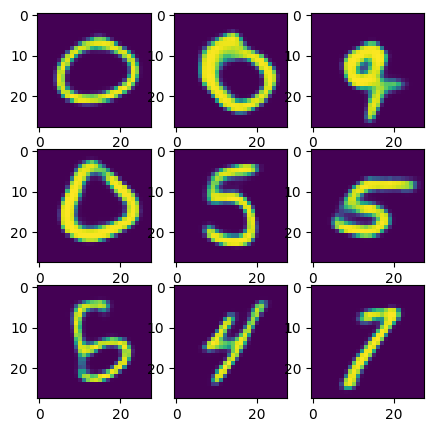

1875/1875 [==============================] - 4s 2ms/step


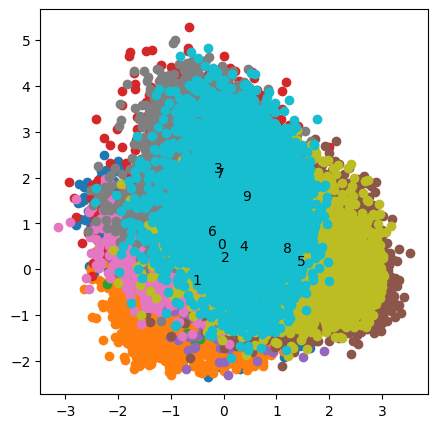

Cluster Validity Metrics (Autoencoder 1):
Silhouette Score: 0.14162932
Davies-Bouldin Index: 1.936476425706985
Calinski-Harabasz Index: 5496.002617976356


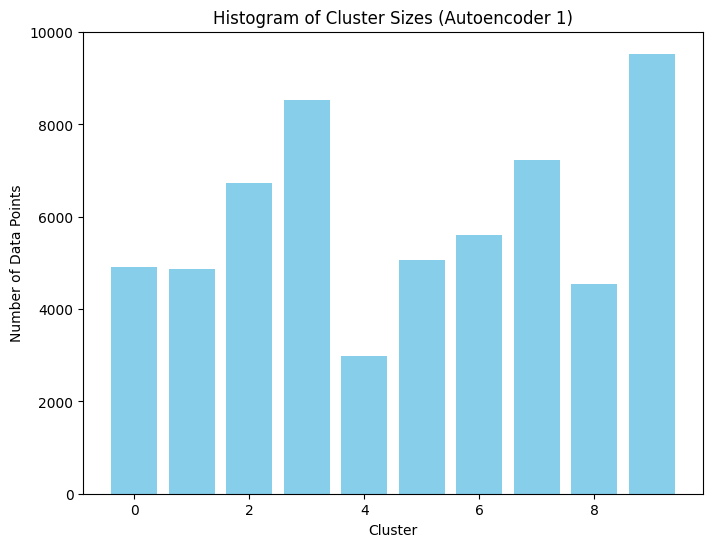

In [9]:
#Добавить класификатор, на вход которого подключен предобученный энкодер
# получаем выход автоэнкодера, изображения который он получает
index = numpy.random.randint(0,len(all_image),9)
out_img = autoencoder.predict(all_image[index])
# выводим их на графике
fig = plt.figure(figsize=(5,5))
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3,3,i*3+j+1)
        ax.imshow(out_img[i*3+j][:,:,0])
plt.show()
# реализуем работу  с энкодером получая скрытый кодовый слой
out_vec = encoder.predict(all_image)
out_vec_save = out_vec;
# получим центроиды кластеров для 10 кластеров
centroid, label = kmeans2(out_vec, num_classes, minit='++')

# получим центроиды кластеров для 2 кластеров
centroid1, label1 = kmeans2(out_vec, 2, minit='++')

# считаем координаты кластера как разность с центроидом
out_vec1 = (out_vec - centroid1[0])**2
out_vec2 = (out_vec - centroid1[1])**2
# берем среднее значение
outm = out_vec1.mean(axis=1)
outstd = out_vec2.mean(axis=1)

coutm = centroid.mean(axis=1)
coutstd = centroid.mean(axis=1)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
# рисуем на графике кластер объектов в виде среднее дисперсия
for i in range(num_classes):
  mask = label == i
  ax.scatter(out_vec[mask,0],out_vec[mask,1])
  plt.text(centroid[i,0], centroid[i,1], i , fontdict=None)
plt.show()

# Compute silhouette score
silhouette = silhouette_score(out_vec, label)

# Compute Davies-Bouldin index
davies_bouldin = davies_bouldin_score(out_vec, label)

# Compute Calinski-Harabasz index
calinski_harabasz = calinski_harabasz_score(out_vec, label)

# Print the cluster validity metrics
print("Cluster Validity Metrics (Autoencoder 1):")
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

centroid, label = kmeans2(out_vec, num_classes, minit='++')

# Count the number of data points in each cluster
cluster_sizes = numpy.bincount(label)

# Plot a histogram of cluster sizes
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_sizes)), cluster_sizes, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Histogram of Cluster Sizes (Autoencoder 1)')
plt.show()

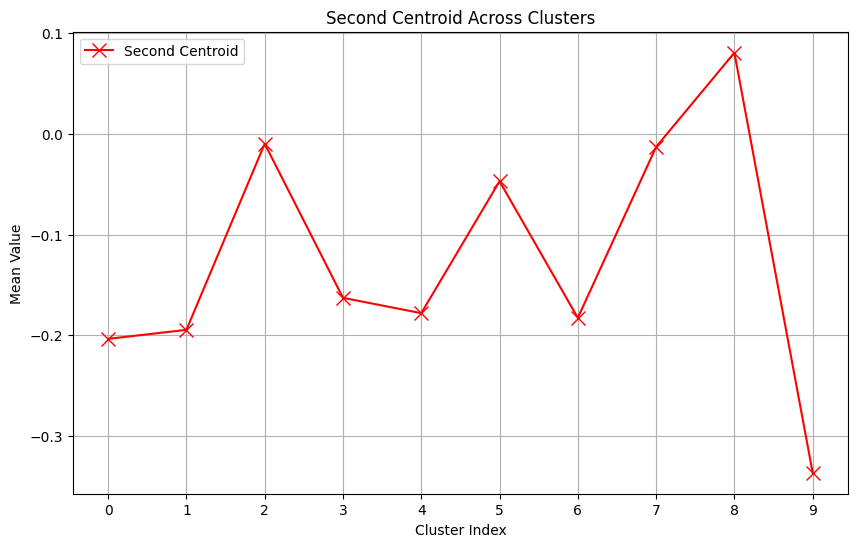

In [10]:
# Новый график
# Визуализация второй центроиды кластера

plt.figure(figsize=(10, 6))

# Рисуем линейчатый график для среднего значения второй центроиды по класстерам
plt.plot(range(len(coutm)), coutm, marker='x', color='red', markersize=10, label='Second Centroid')

plt.title('Second Centroid Across Clusters')
plt.xlabel('Cluster Index')
plt.ylabel('Mean Value')
plt.xticks(range(10))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
encoder = krs.models.load_model("encoder_model.keras")
encoder.trainable = False

(trainx, trainy), (testx, testy) = mnist.load_data()
all_image = (trainx/255.0-0.5)*1.999
# добавляем дополнительное измерение соответствующее одной цветовой карте
all_image = numpy.expand_dims(all_image, axis=3)

out_vec_save = encoder.predict(all_image)
all_out = krs.utils.to_categorical(trainy)

In [ ]:
all_out = krs.utils.to_categorical(trainy)
num_classes = 10
num_hide = 98
batch_size_t = 128
n_count = 128
ep = 20
activation_func = 'relu'

# Define classifier model
classifier_input = Input(shape=(num_hide,))
x = Dense(n_count, activation='relu')(classifier_input)
x = Dropout(0.5)(x)  # Dropout layer for regularization
classifier_output = Dense(num_classes, activation='softmax')(x)
classifier_model = Model(classifier_input, classifier_output)

# Compile classifier model with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Use 'learning_rate' instead of 'lr'
classifier_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train classifier model with data augmentation and early stopping
history = classifier_model.fit(out_vec_save, all_out, epochs=ep, batch_size=batch_size_t, validation_split=0.1, callbacks=[early_stopping])
classifier_model.save('classifier_history.keras')

In [ ]:
# Evaluate classifier model
test_image = (testx / 255.0 - 0.5) * 1.999
test_image = numpy.expand_dims(test_image, axis=3)
test_out_vec = encoder.predict(test_image)
test_out = krs.utils.to_categorical(testy)
accuracy = classifier_model.evaluate(test_out_vec, test_out)
print("Test Accuracy:", accuracy[1])
y_pred_proba = classifier_model.predict(test_out_vec)

In [24]:
all_out = krs.utils.to_categorical(trainy)
num_classes = 10
num_hide = 98
n_count = 128
dropout= 0.2
ep = 80
activation_func = 'relu'

classifier_input = krs.layers.Input(shape=(num_hide,))
encoder.trainable = False

lay = krs.layers.Dense(n_count, activation=activation_func)(classifier_input)
lay = krs.layers.Dropout(dropout)(lay)
lay = krs.layers.Dense(n_count * 2, activation=activation_func)(lay)
lay = krs.layers.Dropout(dropout)(lay)
lay = krs.layers.Dense(n_count * 4, activation=activation_func)(lay)
lay = krs.layers.Dropout(dropout)(lay)
lay = krs.layers.Dense(n_count * 2, activation=activation_func)(lay)
lay = krs.layers.Dropout(dropout)(lay)
lay = krs.layers.Dense(n_count, activation=activation_func)(lay)
lay = krs.layers.BatchNormalization()(lay)
lay = krs.layers.Dense(num_classes, activation=activation_func, kernel_initializer='random_uniform')(lay)
classifier_output = krs.layers.Dense(num_classes, activation="tanh", name='den4')(lay)

print('Shape of classifier_output:', classifier_output.shape)
classificator = krs.Model(classifier_input, classifier_output)
classificator.compile(loss='binary_crossentropy', optimizer=krs.optimizers.Adam(learning_rate = 0.001),
                      metrics=['accuracy', krs.metrics.Precision(), krs.metrics.Recall()])
classificator.fit(x = out_vec_save, y = all_out, batch_size = 8000 ,epochs = ep)

test_out_vec = encoder.predict(numpy.expand_dims((testx/255.0-0.5)*1.999, axis=3))
y_pred_proba = classifier_model.predict(test_out_vec)
predictions = classificator.predict(test_out_vec)
classificator.save('classificator_model.keras')

Shape of classifier_output: (None, 10)
Epoch 1/50
2/2 [==============================] - 3s 271ms/step - loss: 0.6690 - accuracy: 0.1582 - precision_15: 0.1257 - recall_15: 0.5572
Epoch 2/50
2/2 [==============================] - 1s 276ms/step - loss: 0.5578 - accuracy: 0.2872 - precision_15: 0.1829 - recall_15: 0.5915
Epoch 3/50
2/2 [==============================] - 1s 276ms/step - loss: 0.5006 - accuracy: 0.3159 - precision_15: 0.2028 - recall_15: 0.5378
Epoch 4/50
2/2 [==============================] - 1s 278ms/step - loss: 0.4575 - accuracy: 0.3580 - precision_15: 0.2172 - recall_15: 0.5005
Epoch 5/50
2/2 [==============================] - 1s 274ms/step - loss: 0.4239 - accuracy: 0.3899 - precision_15: 0.2412 - recall_15: 0.5061
Epoch 6/50
2/2 [==============================] - 1s 276ms/step - loss: 0.3989 - accuracy: 0.4104 - precision_15: 0.2585 - recall_15: 0.5112
Epoch 7/50
2/2 [==============================] - 1s 275ms/step - loss: 0.3800 - accuracy: 0.4021 - precision_15: 0

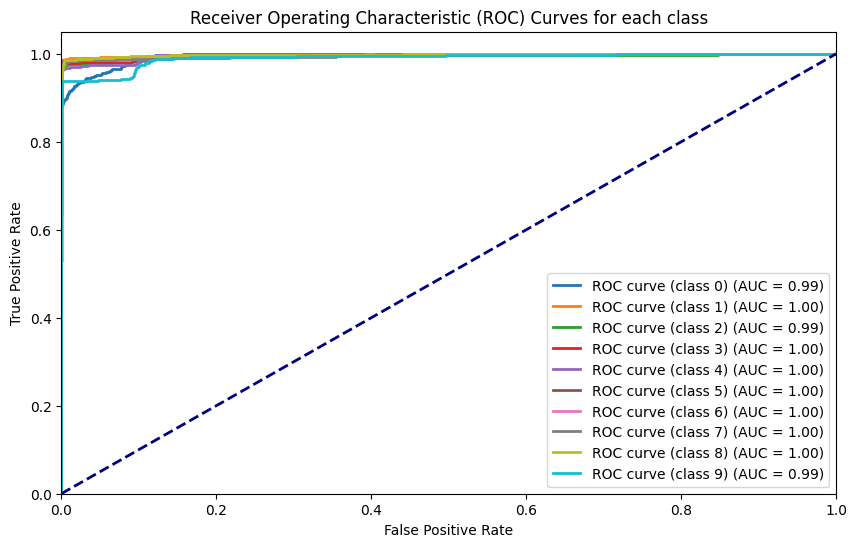

In [25]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # Assuming you have 10 classes
    fpr[i], tpr[i], _ = roc_curve(test_out[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(test_out.ravel(), y_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='red', lw=2, label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc_micro))
for i in range(10):  # Assuming you have 10 classes
    plt.plot(fpr[i], tpr[i], lw=1, label='ROC curve of class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifier Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess data
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to one-hot encoding
num_classes = 10
y_train = numpy.eye(num_classes)[y_train]
y_test = numpy.eye(num_classes)[y_test]

# Build CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1)

# Predict probabilities
y_pred_proba = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test)
plt.text(0.5, 0.05, 'Accuracy on Test Data: {:.2f}%'.format(accuracy*100), ha='center')
plt.show()

In [26]:
out_img_predict = classificator.predict(out_vec_save)
numer_out = 0
for i in range(17):
  for j in range(10):
    if all_out[i][j] == 1:
      numer_out = j
  print(out_img_predict[i][numer_out], 9 - numer_out)
  # print(out_img_predict[i], all_out[i])

1875/1875 [==============================] - 4s 2ms/step
0.97846 4
0.92290986 9
0.81236976 5
0.95328426 8
0.95612776 0
0.91459286 7
0.95835763 8
0.997623 6
0.9545546 8
0.93509156 5
0.9957113 6
0.99149406 4
0.9991536 6
0.9837569 3
0.95533115 8
0.49465996 2
0.911298 7


In [12]:
out_img_predict = classificator.predict(out_vec_save)
for i in range(17):
  print(out_img_predict[i], all_out[i])

1875/1875 [==============================] - 4s 2ms/step
[8.8521630e-02 2.0004775e-04 1.0878370e-02 4.9039349e-02 1.2649130e-04
 8.2688296e-01 1.3505317e-02 7.7519164e-04 1.0045522e-02 2.5080832e-05] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[9.8166955e-01 4.4300576e-04 3.0901681e-03 1.9058828e-03 1.1999075e-03
 6.3140751e-03 1.6346778e-03 1.6831704e-03 1.4947103e-04 1.9100060e-03] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[6.73302934e-02 3.80641944e-03 2.62510474e-03 5.36100270e-05
 6.99259996e-01 3.08467483e-04 6.07667938e-02 3.71919088e-02
 1.26050580e-02 1.16052315e-01] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[2.4441234e-03 8.7909687e-01 2.0696245e-02 3.2149688e-05 1.1462829e-03
 6.6116088e-05 7.3959529e-02 3.0394380e-03 1.0510910e-03 1.8468065e-02] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[4.0227789e-03 3.2235544e-02 9.9871343e-04 2.4289432e-06 1.8644907e-02
 2.2510377e-04 4.1055279e-03 1.0936299e-02 8.9518144e-04 9.2793351e-01] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[2.7585963e-02 9.0989694e-03 9.5075250e-01 9.2150121e-06 